### Notebook to explore supervised seg - personal edification only; not of scientific interest

In [1]:
import numpy as np
import os, sys, shutil
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import json, pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics
sys.path.insert(0, '../utils')
import data_utils, run_utils, eval_utils
import importlib

#### UNet for Supervised Segmentation

UNet: 13
Total validation accuracy: 88.82%
	84.28419341771152% of intergranule pixels correctly identified
	50.323578356390044% of dim middle pixels correctly identified
	93.32656484439849% of granule pixels correctly identified
	78.5753727222529% of bright point pixels correctly identified


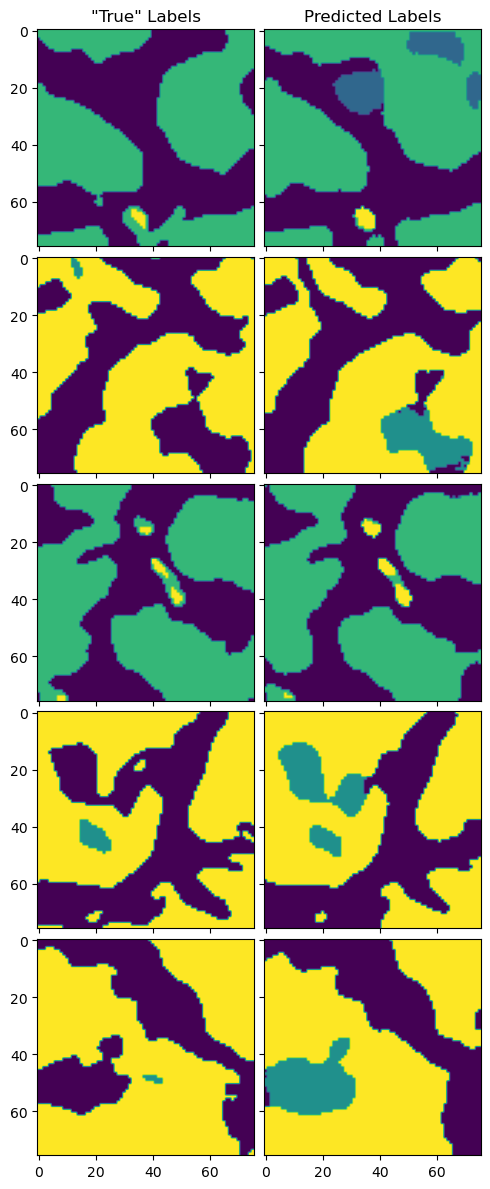

In [23]:
'''
Explore results of one model
'''

UNet_num = '13'
n_classes = 4

# Compute total validation accuracy
output_dir = f'../../model_runs_mag/exp{UNet_num}/UNet{UNet_num}_outputs'
pct_correct, pct_ig_correct, pct_dm_correct, pct_gr_correct, pct_bp_correct = run_utils.segmentation_validation_results(output_dir, n_classes)
print(f'UNet: {UNet_num}')
print(f"Total validation accuracy: {pct_correct:.2f}%") 
print(f'\t{pct_ig_correct}% of intergranule pixels correctly identified')
print(f'\t{pct_dm_correct}% of dim middle pixels correctly identified')
print(f'\t{pct_gr_correct}% of granule pixels correctly identified')
print(f'\t{pct_bp_correct}% of bright point pixels correctly identified')

# Display a random sample of images
fig, axs = plt.subplots(5, 2, figsize=(5, 12), sharex=True, sharey=True)
axs[0,0].set_title('"True" Labels')
axs[0,1].set_title('Predicted Labels')
for i in range(5):
    idx = np.random.randint(0, 396)
    im = np.load(f'{output_dir}/x_{idx}.npy')[0] # first index to get image
    true = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    axs[i,0].imshow(true) # vmin=0, vmax=1.5
    axs[i,1].imshow(preds) # vmin=0, vmax=1.5
fig.tight_layout()
plt.subplots_adjust(hspace=0.05)

#### Traditional ML for Segmentation

As expected, models are successfull at learning the thresholding perfectly

In [3]:
'''
Compare various models
'''

# Compile data (concate series 183653) 
data = []
labels = []
for file in os.listdir('../../Data/DKIST_gband_Feb06_series_183653/'):
        if file.startswith('SEG_VBI'):
            dat = fits.open('../../Data/DKIST_gband_series_183653/'+file)
            img = dat[1].data.byteswap().newbyteorder()
            seg = dat[0].data.byteswap().newbyteorder()[0]
            data = np.concatenate((data, img), axis=1)
            labels = np.concatenate((labels, seg), axis=1)

# Prepare half for training and testing (split along 'short' axis to encompass all)
tt_data = data[0:int(np.shape(data)[0]/2), :]
tt_labels = labels[0:int(np.shape(data)[0]/2), :]
X_tt, Y_tt = data_utils.pre_proccess(tt_data, tt_labels)
X_train, X_test, Y_train, Y_test = train_test_split(X_tt, Y_tt, test_size=0.4, random_state=20)

# Prepare other half for test
tt_data = data[int(np.shape(data)[0]/2):-1, :]
tt_labels = labels[int(np.shape(data)[0]/2):-1, :]
X_test, Y_test = data_utils.pre_proccess(tt_data, tt_labels)

# RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, Y_train)
pred = model.predict(X_test)
print('RF test accuracy:', metrics.accuracy_score(Y_test, pred))

# KNeighborsClassifier 
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, Y_train)
pred =  model.predict(X_test)
print('KNN test accuracy:', metrics.accuracy_score(Y_test, pred))


TypeError: list indices must be integers or slices, not tuple

Train data:
     1890 obs, broken into 119 batches
     Each batch has data of shape torch.Size([16, 1, 128, 128]), e.g. 16 images, [128, 128] pixels each, 1 layers (features)
     Each batch has labels of shape torch.Size([16, 1, 128, 128]), e.g. 16 images, [128, 128] pixels each, 1 layers (classes)
torch.Size([16, 1, 128, 128]) torch.Size([16, 1, 128, 128])


NameError: name 'b' is not defined

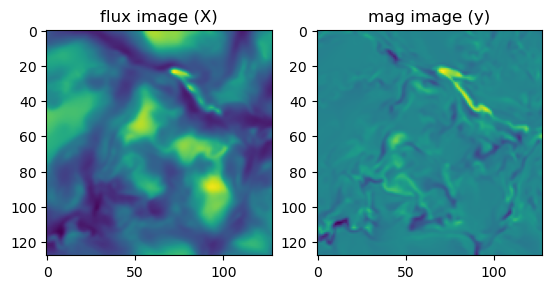

In [2]:
'''
Check supervised mag prediction dataset
'''
from torch.utils.data import Dataset, TensorDataset, DataLoader
d = json.load(open('../../model_runs_seg/UNet_runs/magNetX_1A/exp_file.json'))
UNet_name = d['UNet_name']
imgdir = d['img_dir']
truedir = d['true_dir'] # mag images
channels = d['channels'] 
im_size = 128
in_channels = int(channels[0][channels[0].find('_')+1:]) if channels[0].startswith('time') else len(channels)
target_pos = int(np.floor(in_channels/2)) if channels[0].startswith('time') else 0 # position of target within channels axis
train_ds = data_utils.dataset(image_dir=imgdir, mask_dir=truedir, set='train', norm=False, n_classes=d['n_classes'], channels=channels, randomSharp=d['randomSharp'], im_size=im_size) # multichannel=True, channels=['deltaBinImg'], 
train_loader = DataLoader(train_ds, batch_size=d['batch_size'], pin_memory=True, shuffle=True)
data_utils.check_inputs(train_ds, train_loader, savefig=False, name=UNet_name)
for dat, targ in train_loader:
    print(dat.shape, targ.shape)
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(dat[0,0,:,:]); axs[0].set_title('flux image (X)')
    axs[1].imshow(targ[0,0,:,:]); axs[1].set_title('mag image (y)')
    a=b
    
    